# Log Return Analysis

This notebook analyzes the log returns of the four bar types, Time Bar, Tick Bar, Volume Bar and Dollar Bar. 

**Hightlights**:

* Log returns are stationary time series data but not white noise, which means there are patterns inside them, see Section 2.7 and 2.8.
* Tick Bar, Volume Bar and Dollar Bar have higher autocorrelation than Time Bar, see Section 4.
* Volume Bar and Dollar Bar are closer to normal distribution than Time Bar and Tick Bar, see Section 5.
* Tick Bar, Volume Bar and Dollar Bar significantly sample more information than Time Bar during high-activity period, see Section 2.3.

In [1]:
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller as ADF

In [2]:
np.random.seed(987654321) # set random seed to get the same result

In [3]:
from utils import read_bars as read_bars_tmp

# Read bars in May 2020
def read_bars(csv_file: str)->pd.DataFrame:
    TIME_BEGIN = pd.to_datetime('2020-05-01T00:00:00.000Z').tz_localize(None)
    TIME_END = pd.to_datetime('2020-06-01T00:00:00.000Z').tz_localize(None)
    bars_df = read_bars_tmp(csv_file)
    bars_df = bars_df[(bars_df['timestamp'] >= TIME_BEGIN) & (bars_df['timestamp_end'] < TIME_END)]
    return bars_df

## 1. Read Bars Data

In [4]:
# Bars are built by ../bars/standard-bars.ipynb
time_bars = read_bars('/data/bars/TimeBar/4000/TimeBar.4000.Binance.Swap.BTC_USDT.csv')
tick_bars = read_bars('/data/bars/TickBar/32/TickBar.32.Binance.Swap.BTC_USDT.csv')
volume_bars = read_bars('/data/bars/VolumeBar/16/VolumeBar.16.Binance.Swap.BTC_USDT.csv')
dollar_bars = read_bars('/data/bars/DollarBar/160000/DollarBar.160000.Binance.Swap.BTC_USDT.csv')

In [5]:
time_bars.head()

,exchange,market_type,pair,bar_type,bar_size,timestamp,timestamp_end,open,high,low,...,median,volume,volume_sell,volume_buy,volume_quote,volume_quote_sell,volume_quote_buy,count,count_sell,count_buy
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-01 00:00:04,Binance,Swap,BTC_USDT,TimeBar,4000,2020-05-01 00:00:04,2020-05-01 00:00:08,8623.610352,8626.419922,8619.839844,...,8622.750000,30.410,16.065,14.345000,262229.44,138546.330,262213.38,43,22,21
2020-05-01 00:00:08,Binance,Swap,BTC_USDT,TimeBar,4000,2020-05-01 00:00:08,2020-05-01 00:00:12,8626.349609,8627.400391,8622.000000,...,8624.959961,30.882,19.081,11.801000,266359.62,164570.660,266340.56,56,30,26
2020-05-01 00:00:12,Binance,Swap,BTC_USDT,TimeBar,4000,2020-05-01 00:00:12,2020-05-01 00:00:16,8625.209961,8627.059570,8621.040039,...,8624.629883,12.968,6.792,6.176000,111853.37,58592.465,111846.58,51,13,38
2020-05-01 00:00:16,Binance,Swap,BTC_USDT,TimeBar,4000,2020-05-01 00:00:16,2020-05-01 00:00:20,8622.480469,8625.139648,8622.169922,...,8623.189453,7.650,5.312,2.338000,65969.82,45809.566,65964.51,34,19,15
2020-05-01 00:00:20,Binance,Swap,BTC_USDT,TimeBar,4000,2020-05-01 00:00:20,2020-05-01 00:00:24,8624.940430,8630.379883,8624.879883,...,8629.290039,87.465,67.373,20.092001,754749.94,581370.400,754682.56,77,54,23


In [6]:
print('num_time_bars: %d, num_tick_bars: %d, num_volume_bars: %d, num_dollar_bars: %d' % (
    time_bars.shape[0], tick_bars.shape[0], volume_bars.shape[0], dollar_bars.shape[0]
))

num_time_bars: 640388, num_tick_bars: 714675, num_volume_bars: 705217, num_dollar_bars: 652755


## 2. Data Exploration

### 2.1 Plot price

Text(0.5, 1.0, 'Close Price')

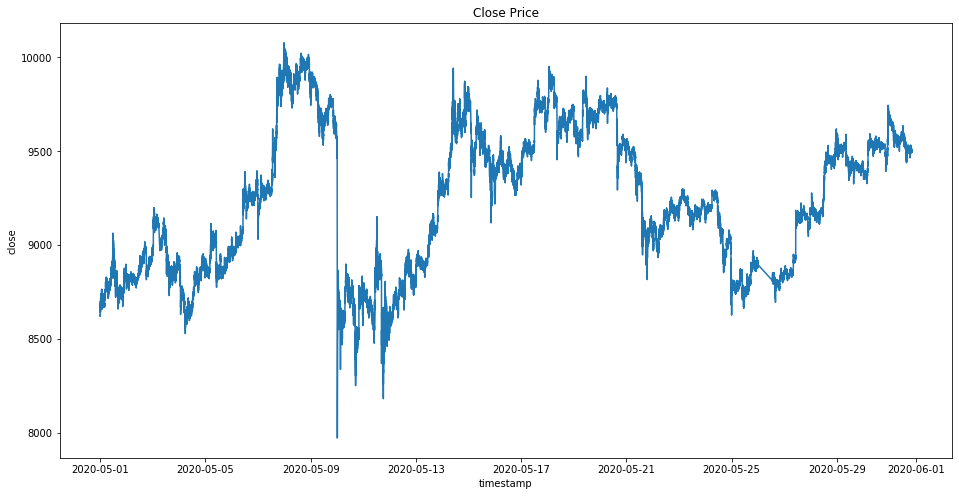

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=time_bars.index, y=time_bars['close'], ax=ax).set_title('Close Price')

From the plot of price against time, we can find that Bitcoin prices oscillate around \\$9000 in May 2020, and there was flash crash at 2020-05-09, the price crashed from \\$1000 to \\$8000.

### 2.2 Plot return and log return

Both return and log return are a kind of `differencing`, which is a commonly used method to in time series analysis. Differencing can generate more stationary time series data than raw prices.

In [6]:
def get_returns(time_bars: pd.DataFrame)->pd.DataFrame:
    time_gaps = time_bars['timestamp'].diff(1).dropna().rename('gap')
    returns = time_bars['close'].pct_change().dropna().rename('return')
    log_returns = np.log(time_bars['close']).diff().dropna().rename('log_return')
    returns_df = pd.concat([time_gaps, returns, log_returns], axis=1)
    # remove outliers
    return returns_df[returns_df['gap']<=pd.Timedelta(seconds=4)][['return', 'log_return']]

In [7]:
returns_df = get_returns(time_bars)

In [10]:
returns_df.head()

,return,log_return
timestamp,,
2020-05-01 00:00:08,-0.000136,-0.000135
2020-05-01 00:00:12,-0.000454,-0.000455
2020-05-01 00:00:16,0.000353,0.000353
2020-05-01 00:00:20,0.000617,0.000616
2020-05-01 00:00:24,-0.000113,-0.000113


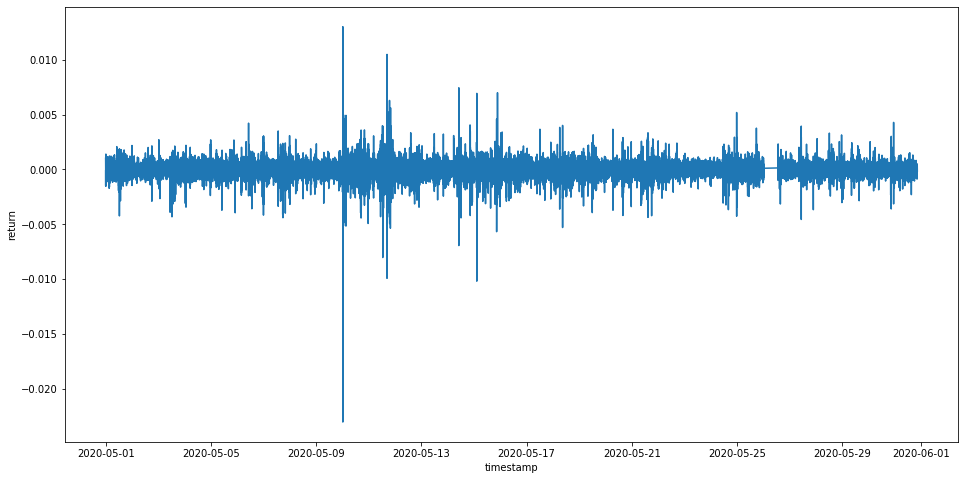

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=returns_df.index, y=returns_df['return'], ax=ax)

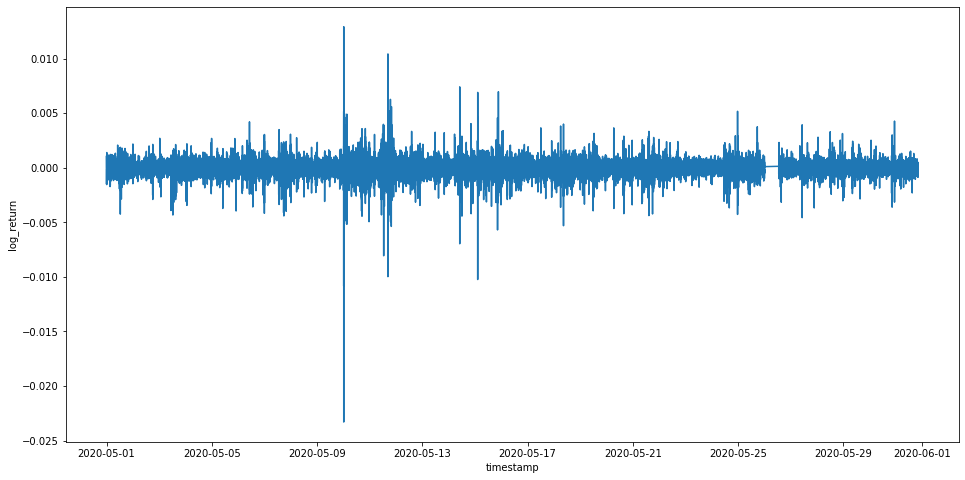

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=returns_df.index, y=returns_df['log_return'], ax=ax)

In log returns agains time chart above, we can see that the mean of log returns is almost zero, but the volatility becomes larger at 2020-05-09 because there was a flash crash. This phenomenon is consistent with the price chart, that at 2020-05-09, there existed significantly fluctuations.

At 2020-05-26 there was a blank gap because the crawler were down for a day, thus the data were missing.

### 2.3 Zoom in on the flash crash

In [63]:
def zoom_in_flash_crash():
    # Flash crash time range
    time_begin = pd.to_datetime(1589069400000, unit='ms')  # 2020-05-10T00:10:00.000Z
    time_end = pd.to_datetime(1589070120000, unit='ms')    # 2020-05-10T00:22:00.000Z
    time_bars_short = time_bars[(time_bars['timestamp'] >= time_begin) & (time_bars['timestamp_end'] < time_end)].copy(deep=True)
    tick_bars_short = tick_bars[(tick_bars['timestamp'] >= time_begin) & (tick_bars['timestamp_end'] < time_end)].copy(deep=True)
    volume_bars_short = volume_bars[(volume_bars['timestamp'] >= time_begin) & (volume_bars['timestamp_end'] < time_end)].copy(deep=True)
    dollar_bars_short = dollar_bars[(dollar_bars['timestamp'] >= time_begin) & (dollar_bars['timestamp_end'] < time_end)].copy(deep=True)
    print(f'num_time_bars: {time_bars_short.shape[0]}, num_tick_bars: {tick_bars_short.shape[0]}, num_volume_bars: {volume_bars_short.shape[0]}, num_dollar_bars: {dollar_bars_short.shape[0]}')

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 8), sharex=True, sharey=True)
    sns.lineplot(x=time_bars_short.index, y=time_bars_short['close'], ax=axes[0, 0], color='royalblue').set_title('Time Bar')
    sns.lineplot(x=tick_bars_short.index, y=tick_bars_short['close'], ax=axes[0, 1], color='royalblue').set_title('Tick Bar')
    sns.lineplot(x=volume_bars_short.index, y=volume_bars_short['close'], ax=axes[1, 0], color='royalblue').set_title('Volume Bar')
    sns.lineplot(x=dollar_bars_short.index, y=dollar_bars_short['close'], ax=axes[1, 1], color='royalblue').set_title('Dollar Bar')

num_time_bars: 178, num_tick_bars: 3112, num_volume_bars: 5156, num_dollar_bars: 4577


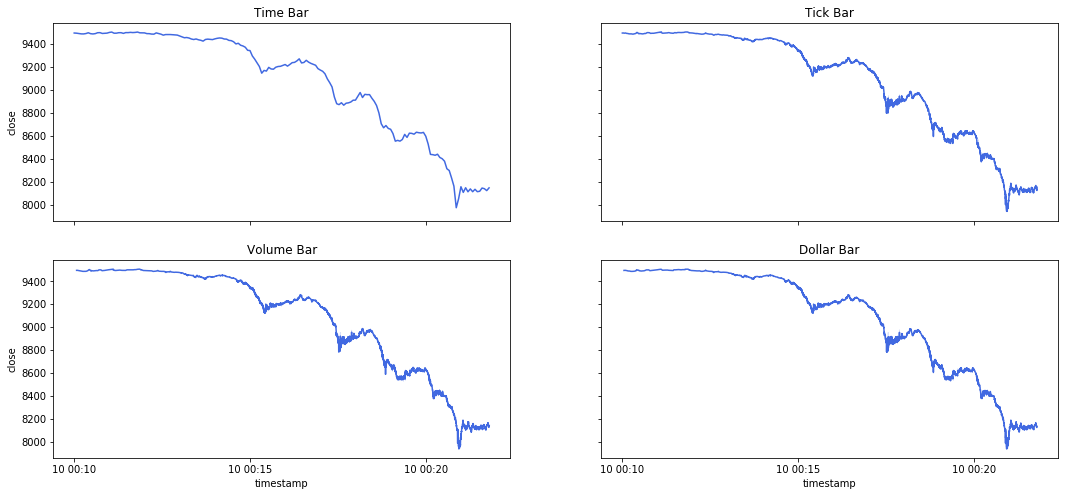

In [64]:
zoom_in_flash_crash()

From the four charts above, we can see that tick bars, volume bars and dollar bars are better than time bars, because they sample more information during high-activity period.

### 2.4 Description of Returns and Log Returns

In [15]:
log_returns_desc = returns_df.describe(percentiles=[0.5, 0.95])
log_returns_desc.loc['var'] = returns_df.var().tolist()
log_returns_desc.loc['skewness'] = returns_df.skew().tolist()
log_returns_desc.loc['kurtosis'] = returns_df.kurtosis().tolist()

In [16]:
log_returns_desc

,return,log_return
count,6.389410e+05,6.389410e+05
mean,1.711790e-07,1.336954e-07
std,2.737115e-04,2.737700e-04
min,-2.303648e-02,-2.330589e-02
50%,0.000000e+00,0.000000e+00
95%,3.644228e-04,3.643036e-04
max,1.301289e-02,1.292896e-02
var,7.491800e-08,7.495002e-08
skewness,-1.746307e+00,-1.810069e+00
kurtosis,1.542751e+02,1.580000e+02


From the description above, we can see that the kurtosis is 158.0, which is larger than the kurtosis of normal distribution, i.e., 3. So the Bitcoin return has a heavier tail than normal. The skewness is -1.81, which means the distribution of return is asymmetric and the negative value implies that the distribution has a long left tail.

### 2.5 Plot the Distribution

In [8]:
# Normalize the data
log_returns = returns_df['log_return']
mean = log_returns.mean()
std = log_returns.std()
log_returns_norm = (log_returns - mean) / std

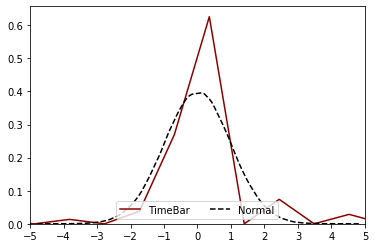

In [18]:
# Plot the Distributions
plt.figure(figsize=(6,4))
sns.kdeplot(log_returns_norm, label="TimeBar", color='darkred')
sns.kdeplot(np.random.normal(size=log_returns.size), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc=8, ncol=4)
plt.xlim(-5, 5)
plt.show()

### 2.6 Autocorrelation

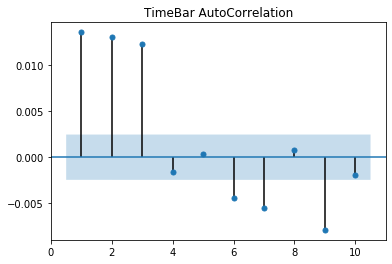

In [19]:
# Exclude lag=0 by setting zero=False, whose autocorr is always 1.0
plot_acf(log_returns, lags=10, zero=False, title='TimeBar AutoCorrelation')
plt.show()

The blue area is 95% confidence interval, suggesting that correlation values outside of this area are very likely a correlation and not a statistical fluke.

In the figure above, significant autocorrs are lag of 1, 2, 3, 6, 7, 9. The first three lags have the highest autocorrelation, which reflects that there is momentum.

### 2.7 Stationarity Test

Stationary time series data have:

* Constant mean
* Constant variance
* Non-zero autocorrelation at some lags

In [20]:
adf_result = ADF(log_returns)

In [21]:
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Used lag: %f' % adf_result[2])
print('Number of observations: %f' % adf_result[3])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -75.141421
p-value: 0.000000
Used lag: 108.000000
Number of observations: 638832.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In the output above, we can see that ADF statistic value of `-75.141421` is less than the value of `-3.430` at 1%.

This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

Besides, the p-value is less than `0.05`, which also rejects the null hypothesis.

**Conclusion: Log returns are stationary time series data.**

### 2.8 White Noise Test

White noise has:

* Constant mean
* Constant variance
* Zero autocorrelation at all lags

White noise has no analysis value, dont' waste time to analyze it.

In [9]:
acorr_ljungbox(log_returns, lags=1, return_df=True)

,lb_stat,lb_pvalue
1,116.93816,2.961594e-27


The p-value is less than 0.05, we can reject the null hypothesis. **In conclusion, log returns are not white noise.**

### 2.9 Normality Test 

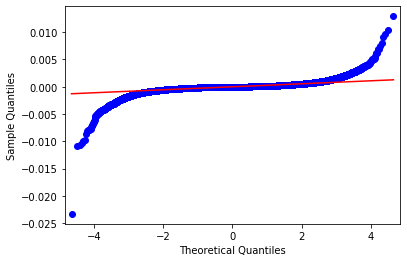

In [25]:
import statsmodels.api as sm

sm.qqplot(log_returns, line='s')
plt.show()

From QQ-Plot we can see that the distribution of log returns have a much heavier tail than normal distribution.

In [26]:
stats.jarque_bera(log_returns)

(664943184.2031091, 0.0)

The JB test statistic is much greater than zero and p-value 0.0 is much less than 0.05, which signals the data do not have a normal distribution.

In [28]:
stats.shapiro(log_returns)

/home/frankdai/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.7437863349914551, 0.0)

In [29]:
stats.kstest(log_returns, 'norm')

KstestResult(statistic=0.49871460239205423, pvalue=0.0)

The p-values of Jarque-Bera test, Shapiro-Wilk test and Kolmogorov–Smirnov are all much less than 0.05, which indicate that log returns do NOT fit a normal distribution.

### 2.10 IID Test

In [30]:
durbin_watson(log_returns)

1.9729416

The Durbin-Watson statistic is less than 2, which means there is positive autocorrelation and log returns are not IID(independent and identically distributed). However, it is very close to 2, so autocorrelation is very week. See [statsmodels.stats.stattools.durbin_watson(https://www.statsmodels.org/stable/generated/statsmodels.stats.stattools.durbin_watson.html).

## 3. Which Bar Type Has the Most Stable Daily Count?

In [31]:
time_count = time_bars['close'].resample('D').count()
tick_count = tick_bars['close'].resample('D').count()
volume_count = volume_bars['close'].resample('D').count()
dollar_count = dollar_bars['close'].resample('D').count()

count_df = pd.concat([time_count, tick_count, volume_count, dollar_count], axis=1)
count_df.columns = ['time', 'tick', 'volume', 'dollar']

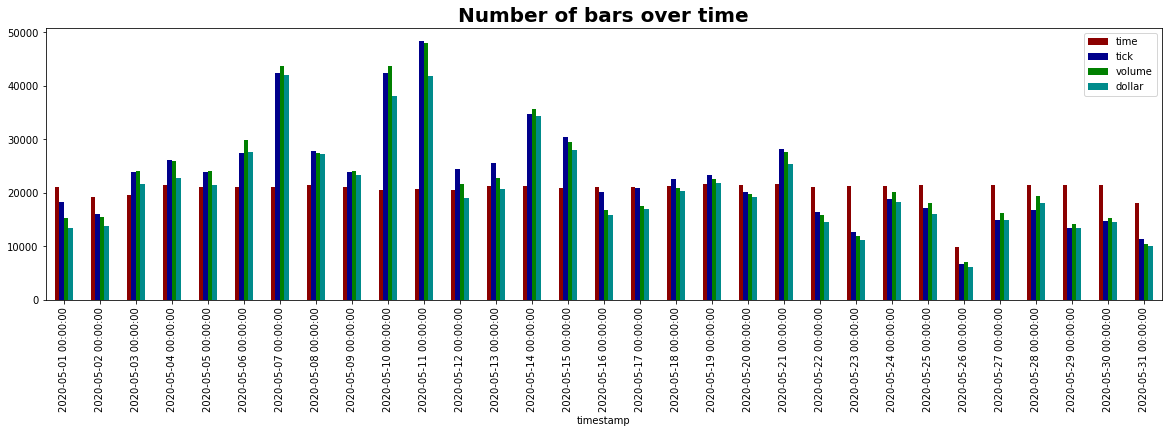

In [32]:
# Plot
count_df.plot(kind='bar', figsize=[20, 5], color=('darkred', 'darkblue', 'green', 'darkcyan'))
plt.title('Number of bars over time', loc='center', fontsize=20, fontweight="bold")
plt.show()

In [33]:
# scale to compare 'apples to apples'
def scale(s: pd.Series)->pd.Series:
    return (s-s.min())/(s.max()-s.min())

count_df['time'] = scale(count_df['time'])
count_df['tick'] = scale(count_df['tick'])
count_df['volume'] = scale(count_df['volume'])
count_df['dollar'] = scale(count_df['dollar'])

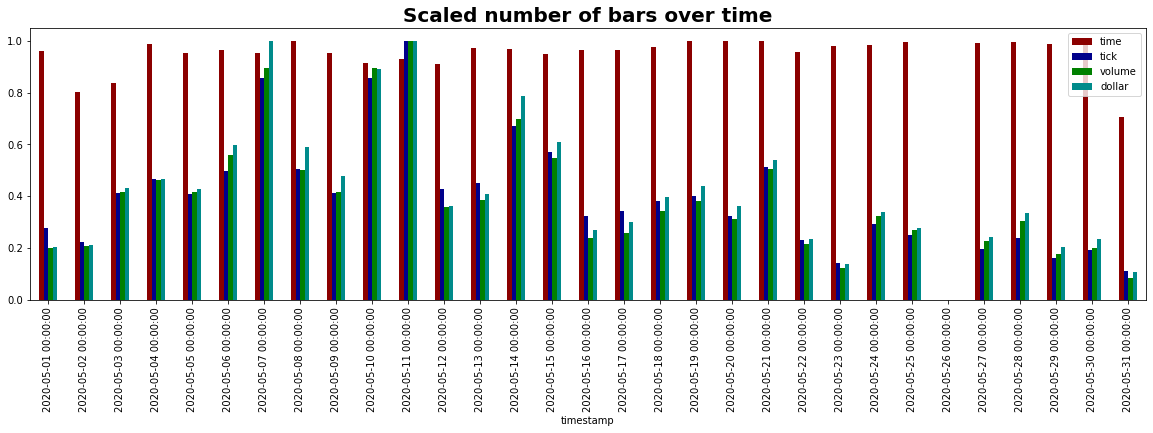

In [34]:
# Plot
count_df.plot(kind='bar', figsize=[20, 5], color=('darkred', 'darkblue', 'green', 'darkcyan'))
plt.title('Scaled number of bars over time', loc='center', fontsize=20, fontweight="bold")
plt.show()

In [35]:
count_df.std().sort_values()

time      0.182431
tick      0.225152
volume    0.235564
dollar    0.245843
dtype: float64

In [36]:
def stable_counts(
    time_bars: pd.DataFrame,
    tick_bars: pd.DataFrame,
    volume_bars: pd.DataFrame,
    dollar_bars: pd.DataFrame,
    interval: str
)->pd.Series:
    time_count = time_bars['close'].resample(interval).count()
    tick_count = tick_bars['close'].resample(interval).count()
    volume_count = volume_bars['close'].resample(interval).count()
    dollar_count = dollar_bars['close'].resample(interval).count()

    count_df = pd.concat([time_count, tick_count, volume_count, dollar_count], axis=1)
    count_df.columns = ['time', 'tick', 'volume', 'dollar']
    
    count_df['time'] = scale(count_df['time'])
    count_df['tick'] = scale(count_df['tick'])
    count_df['volume'] = scale(count_df['volume'])
    count_df['dollar'] = scale(count_df['dollar'])
    
    return count_df.std().sort_values()

In [37]:
stable_counts(time_bars, tick_bars, volume_bars, dollar_bars, '8H')

time      0.133545
tick      0.176971
dollar    0.182805
volume    0.195008
dtype: float64

In [38]:
stable_counts(time_bars, tick_bars, volume_bars, dollar_bars, '4H')

tick      0.142246
time      0.147181
volume    0.148642
dollar    0.159269
dtype: float64

In [39]:
stable_counts(time_bars, tick_bars, volume_bars, dollar_bars, 'H')

volume    0.110492
dollar    0.114127
tick      0.115830
time      0.148959
dtype: float64

In [40]:
stable_counts(time_bars, tick_bars, volume_bars, dollar_bars, 'T')

volume    0.033193
dollar    0.033960
tick      0.044027
time      0.186149
dtype: float64

From the standard deviations above we can see that:

* 8H and 24H are big enough to include a complete cycle, therefore time bars have the most stable counts. Volume bar and dollar bar are less stable because they can sample more during high-activity period and sample less during low-activity period, unlike time bar which sample in constant pace.
* Below 8H bars, which are too small to contain a complete cycle, time bars vary the most.

## 4. Which Bar Type Has the Lowest Serial Correlation?

In [41]:
time_returns = np.log(time_bars['close']).diff().dropna().rename('time_return')
tick_returns = np.log(tick_bars['close']).diff().dropna().rename('tick_return')
volume_returns = np.log(volume_bars['close']).diff().dropna().rename('volume_return')
dollar_returns = np.log(dollar_bars['close']).diff().dropna().rename('dollar_return')

In [42]:
def plot_autocorr():
    f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
    log_returns_arr = [(time_returns, 'TimeBar'), (tick_returns, 'TickBar'), (volume_returns, 'VolumeBar'), (dollar_returns, 'DollarBar')]
    current_palette = sns.color_palette(palette='bright', n_colors=4)
    for i in range(4):
        log_returns, bar_type = log_returns_arr[i]
        plot_acf(log_returns, lags=10, zero=False, ax=axes[i//2, i%2], title=f'{bar_type} AutoCorrelation', color=current_palette[i], )
    plt.tight_layout()

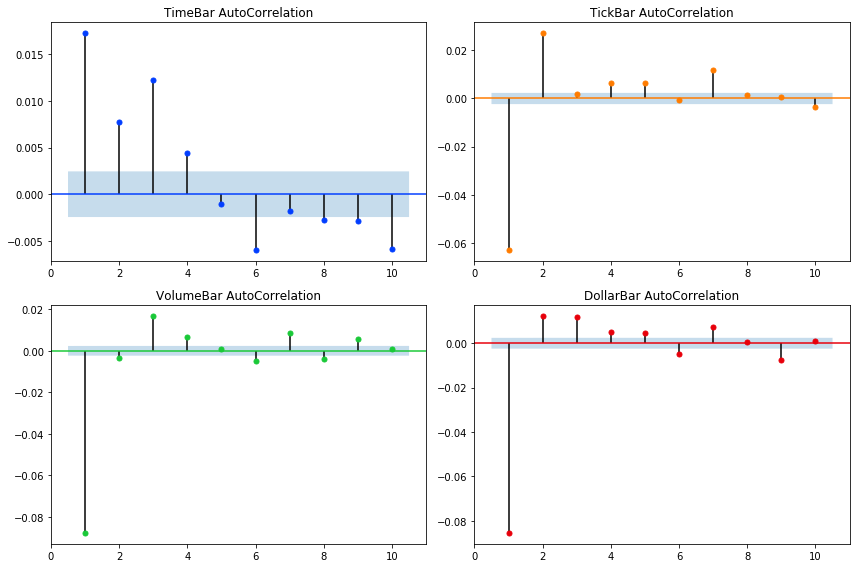

In [43]:
plot_autocorr()

* From the four charts above, we can see that **the absolute values of autocorrelation of TickBar, VolumeBar and DollarBar are higher than TimeBar, which indicates there are stronger patterns than TimeBar.**
* The first, second and third lags of TimeBar have posotive autocorrelations, which indicates there exists momenteum.
* The first lag of TickBar, VolumeBar and DollarBar have negative autocorrelations, which indicates there exist mean-reversion.

In [44]:
def plot_autocorr_hist():
    f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
    log_returns_arr = [(time_returns, 'TimeBar'), (tick_returns, 'TickBar'), (volume_returns, 'VolumeBar'), (dollar_returns, 'DollarBar')]
    current_palette = sns.color_palette(palette='bright', n_colors=4)
    for i in range(4):
        log_returns, bar_type = log_returns_arr[i]
        ax = axes[i//2, i%2]
        g = sns.distplot(log_returns, kde=False, ax=ax, label=bar_type, color=current_palette[i])
        g.set(yscale='log')
        ax.legend()
    plt.tight_layout()

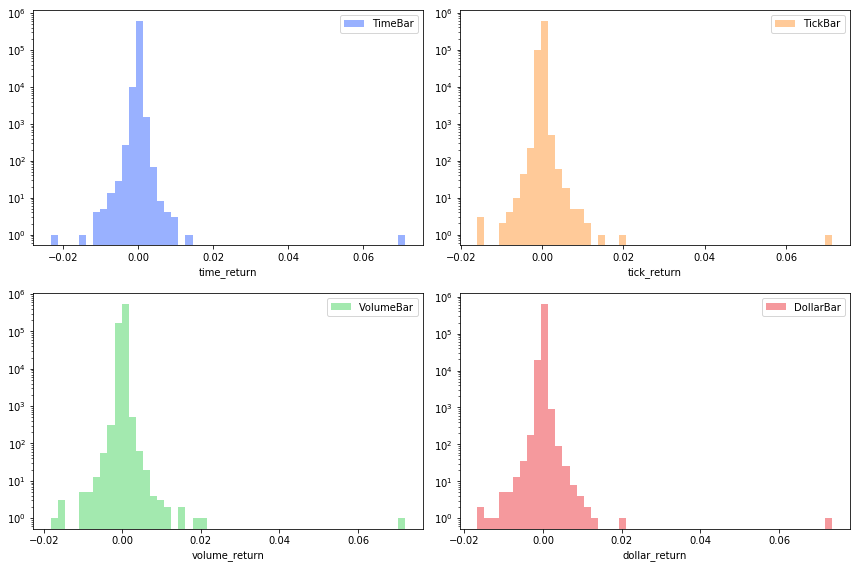

In [45]:
plot_autocorr_hist()

From the charts above we can see that log returns are centered at zero, which is consistent with section 2.2. 

## 5. Which Bar Type Has the Lowest Normality Test Statistic?

Apply the Jarque-Bera normality test on log returns from the four bar types. Which bar type has the lowest test statistic?

In [46]:
stats.jarque_bera(time_returns)

(883054746248.2401, 0.0)

In [47]:
stats.jarque_bera(tick_returns)

(1039343231507.7551, 0.0)

In [48]:
stats.jarque_bera(volume_returns)

(731361322391.54, 0.0)

In [49]:
stats.jarque_bera(dollar_returns)

(725238969169.9047, 0.0)

The Jarque–Bera test statistic is always nonnegative. If it is far from zero, it signals the data do not have a normal distribution. So the lower the better.

From the four results, we can see that all JB test statistics are much greater than zero, which indicate that log returns don't fit a normal distribution. **However DollarBar has the lowest statistic.**

## 6. Compare Shapiro–Wilk test

In [50]:
stats.shapiro(time_returns)

/home/frankdai/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.6676703691482544, 0.0)

In [51]:
stats.shapiro(tick_returns)

(0.7989965677261353, 0.0)

In [52]:
stats.shapiro(volume_returns)

(0.7711598873138428, 0.0)

In [53]:
stats.shapiro(dollar_returns)

(0.7793973088264465, 0.0)

For Shapiro-Wilk test statistic, larger is better. TickBar, VolumeBar and DollarBar have larger test statistic than TimeBar.

## 7. Normalize and Plot the Distributions

In [54]:
# Normalize the data
def normalize(nums: pd.Series)->pd.Series:
    return (nums - nums.mean()) / nums.std()

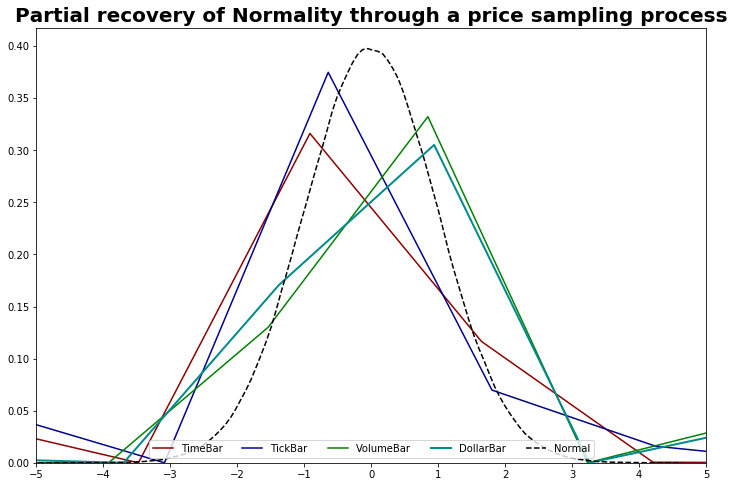

In [55]:
time_returns_norm = normalize(time_returns)
tick_returns_norm = normalize(tick_returns)
volume_returns_norm = normalize(volume_returns)
dollar_returns_norm = normalize(dollar_returns)

# Plot the Distributions
plt.figure(figsize=(12,8))
sns.kdeplot(time_returns_norm, label="TimeBar", color='darkred')
sns.kdeplot(tick_returns_norm, label="TickBar", color='darkblue')
sns.kdeplot(volume_returns_norm, label="VolumeBar", color='green')
sns.kdeplot(dollar_returns_norm, label="DollarBar", linewidth=2, color='darkcyan')

sns.kdeplot(np.random.normal(size=volume_returns_norm.size), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc=8, ncol=5)
plt.title('Partial recovery of Normality through a price sampling process',
          loc='center', fontsize=20, fontweight="bold")
plt.xlim(-5, 5)
plt.show()

## References

* [research/Advances in Financial Machine Learning/Financial Data Structures/Sample_Techniques.ipynb](https://github.com/hudson-and-thames/research/blob/master/Advances%20in%20Financial%20Machine%20Learning/Financial%20Data%20Structures/Sample_Techniques.ipynb)
* [Adv_Fin_ML_Exercises/notebooks/Tick, Volume, Dollar Volume Bars.ipynb](https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/Tick%2C%20Volume%2C%20Dollar%20Volume%20Bars.ipynb)
* [Chu, J., Nadarajah, S., Chan, S., July 2015. Statistical analysis of the exchange rate of bitcoin. PLOS ONE 10 (7).](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0133678)
* [Time Series Analysis for Log Returns of S&P500](https://ionides.github.io/531w18/midterm_project/project38/Midterm_proj.html)
* [Time Series Analysis for Stock Data](https://ionides.github.io/531w16/midterm_project/project21/531-Midterm_Project.html)
* [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)
* [Jarque–Bera test - Wikipedia](https://en.wikipedia.org/wiki/Jarque–Bera_test)
* [Shapiro–Wilk test - Wikipedia](https://en.wikipedia.org/wiki/Shapiro–Wilk_test)
* [Everything you can do with a time series | Kaggle](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series)